In [1]:
# SIPP Portfolio Performance.
import numpy as np
import pandas as pd
import plotly.graph_objects as go

In [2]:
# Parameters.
portfolio_name = 'SIPP-G'

In [3]:
# Import portfolio holdings.
dh = pd.read_csv(
    f'{portfolio_name}_holdings.csv',
    header=0,
    names=[
        'date',
        'name',
        'tidm',
        'shares',
        'price',
        'cost',
        'charges',
        'sduty',
        'value',
        'unrealised',
        'profit',
        'pct_return',
        'pct_annual',
    ],
    index_col=0,
    usecols=['date', 'name', 'tidm', 'profit'],
    engine='python',
    skipfooter=1,
    parse_dates=True,
    dayfirst=True,
)

# Filter portfolio holdings for closed positions.
dh = dh[dh.name == 'Position Closed']
dh = dh.sort_index()

# Calculate cumulative profit of portfolio holdings.
holdings = dh.copy()
holdings['cum_profit'] = holdings.profit.cumsum()

In [4]:
# Import portfolio transactions.
dt = pd.read_csv(
    f'{portfolio_name}_transactions.csv',
    header=0,
    names=[
        'date',
        'time',
        'ionic_id',
        'ticker',
        'type',
        'shares',
        'price',
        'broker',
        'stamp',
        'total',
        'non_cash',
        'note'
    ], 
    index_col=0,
    usecols=['date', 'type', 'total'],
    parse_dates=True,
    dayfirst=True,
)

# Filter portfolio transactions for credits, interest, & charges.
dt = dt[(dt.type == 'Credit') | (dt.type == 'Interest') | (dt.type == 'Charges')]
dt = dt.sort_index()

# Calculate cumulative total of portfolio transactions.
cash = dt.copy()
cash.total = np.where(cash.type == 'Charges', -(cash.total), cash.total)
cash['cum_total'] = cash.total.cumsum()

In [5]:
# Calculate total portfolio value (holdings + cash)
portfolio = pd.DataFrame(columns=['total', 'cum_total'])
portfolio.total = pd.concat([holdings.profit, cash.total], axis=0)
portfolio = portfolio.sort_index()
portfolio.cum_total = portfolio.total.cumsum()

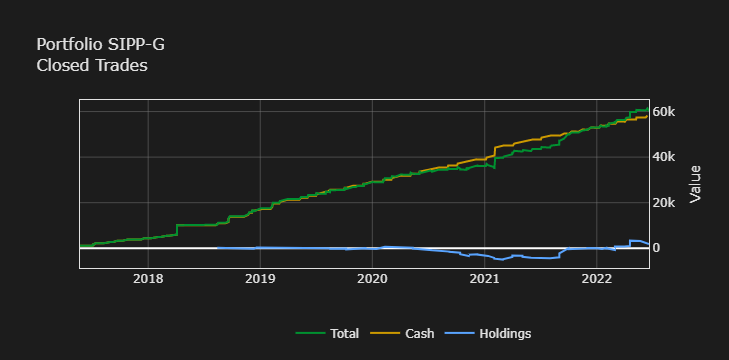

In [8]:
# Create plot series.
ps_holdings = holdings.cum_profit
ps_cash = cash.cum_total
ps_portfolio = portfolio.cum_total

# Create plot traces.
trace_holdings = go.Scatter(
    x=ps_holdings.index,
    y=ps_holdings.values,
    line=dict(color='rgba(89, 164, 255, 1.0)', width=2.0),
    name='Holdings',
    yhoverformat=".0f",
)

trace_cash = go.Scatter(
    x=ps_cash.index,
    y=ps_cash.values,
    line=dict(color='rgba(204, 153, 0, 1.0)', width=2.0),
    name='Cash',
    yhoverformat=".0f",
)

trace_portfolio = go.Scatter(
    x=ps_portfolio.index,
    y=ps_portfolio.values,
    line=dict(color='rgba(0, 145, 48, 1.0)', width=2.0),
    name='Total',
    yhoverformat=".0f",
)


# Create figure and add trace.
fig = go.Figure(trace_holdings)
fig.add_trace(trace_cash)
fig.add_trace(trace_portfolio)

# Customise plot.
fig.update_layout(
    autosize=True,
    showlegend=True,
    legend=dict(x=0.37, y=-0.3, orientation='h', traceorder='reversed'),
    paper_bgcolor='rgba(28, 28, 28, 1.0)',
    plot_bgcolor='rgba(28, 28, 28, 1.0)',
    font=dict(color='rgba(226, 226, 226, 1.0)'),
    title=dict(
        text=f'Portfolio {portfolio_name}' + f'<br>Closed Trades',
        font_color='rgba(226, 226, 226, 1.0)',
        font_size=16,
    ),
    xaxis=dict(rangeslider=dict(visible=False)),
    hovermode='x unified',
    hoverlabel=dict(bgcolor='rgba(28, 28, 28, 0.5)'),
    dragmode='pan',
)

fig.update_xaxes(
    linecolor='rgba(226, 226, 226, 1.0)',
    gridcolor='rgba(119, 119, 119, 0.5)',
    mirror=True,
)

fig.update_yaxes(
    linecolor='rgba(226, 226, 226, 1.0)',
    gridcolor='rgba(119, 119, 119, 0.5)',
    mirror=True,
    side='right',
    title=f'Value',
)

# Display plot.
fig.show(
    config={
        'scrollZoom': True,
        'modeBarButtonsToRemove': ['zoom', 'select2d', 'lasso2d'],
    }
)